In [ ]:
from google.colab import files
a=files.upload()

Saving aug_train.csv to aug_train.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model  import LogisticRegression



In [ ]:
df=pd.read_csv('/content/aug_train.csv')

In [ ]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
df.dtypes.value_counts

<bound method IndexOpsMixin.value_counts of enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object>

Here we can see only 3 columns with int and float data type (numeric data)


In [ ]:
df.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [ ]:
df.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [ ]:
df.dropna(subset=['gender','company_size','company_type','major_discipline','enrolled_university']).isnull().sum()

enrollee_id                0
city                       0
city_development_index     0
gender                     0
relevent_experience        0
enrolled_university        0
education_level            0
major_discipline           0
experience                 6
company_size               0
company_type               0
last_new_job              23
training_hours             0
target                     0
dtype: int64

In [ ]:
df.dropna().notnull().sum() 
df.dropna()['target'].value_counts()

0.0    7472
1.0    1483
Name: target, dtype: int64

In [ ]:
df['target'].value_counts()/df['target'].value_counts().sum()

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64

In [ ]:
df.dropna()['target'].value_counts() /df.dropna()['target'].value_counts().sum()

0.0    0.834394
1.0    0.165606
Name: target, dtype: float64

In [ ]:
df1=df.dropna()

In [ ]:
df1[['city_development_index','training_hours']].corr()

,city_development_index,training_hours
city_development_index,1.000000,-0.005134
training_hours,-0.005134,1.000000


There is almost no correlation in these two numeric features

In [ ]:
df1['looking'] = df1['target']
df1['notlooking'] = abs(df1['target'] - 1)
df1 = df1.dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df1.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,looking,notlooking
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0,0.0,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0,0.0,1.0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0,1.0,0.0
8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0,1.0,0.0
11,23853,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,5000-9999,Pvt Ltd,1,108,0.0,0.0,1.0


In [ ]:
df1.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
looking                   0
notlooking                0
dtype: int64

As it can be observed that I got rid of all the null values and data has shrinked, but not much as to impact the model, I could have used statistic imputation but chose not to because most of the null values were in categorical features, hence statistical imputation would not be much of a help.

In [ ]:
def generate_odds(df, feature):
  df_odds = df1.groupby(feature)[['looking','notlooking']].sum()
  df_odds['Ratio'] = df_odds['looking'] / df_odds['notlooking']
  df_odds['looking_Total'] = df1['looking'].sum()
  df_odds['notlooking_Total'] = df1['notlooking'].sum()
  df_odds['Ratio_Total'] = df_odds[['looking']].sum()[0] / df_odds[['notlooking']].sum()[0] 
  df_odds['OR'] = df_odds['Ratio'] / df_odds['Ratio_Total']
  df_odds['Index'] = df_odds['OR']*100-100
  df_odds['Dist_looking'] = df_odds['looking']/df_odds['looking_Total']
  df_odds['Dist_notlooking'] = df_odds['notlooking']/df_odds['notlooking_Total']
  df_odds['WoE'] = np.log(df_odds['Dist_looking'] / df_odds['Dist_notlooking'])
  df_odds['IV'] = (df_odds['Dist_looking'] - df_odds['Dist_notlooking']) * np.log(df_odds['Dist_looking'] / df_odds['Dist_notlooking'])
  df_odds['Feature_name'] = feature
  df_odds['Attribute']= df_odds.Feature_name + ' ' + df_odds.index
  return df_odds


In [ ]:
df_odd=pd.DataFrame([])

In [ ]:
df_odd.head()

""


In [ ]:
df_odd = generate_odds(df1,'gender')
df_odd = df_odd.append(generate_odds(df1,'relevent_experience'))
df_odd = df_odd.append(generate_odds(df1,'enrolled_university'))
df_odd = df_odd.append(generate_odds(df1,'education_level'))
df_odd = df_odd.append(generate_odds(df1,'major_discipline'))
df_odd = df_odd.append(generate_odds(df1,'experience'))
df_odd = df_odd.append(generate_odds(df1,'company_size'))
df_odd = df_odd.append(generate_odds(df1,'company_type'))
df_odd = df_odd.append(generate_odds(df1,'last_new_job'))

In [ ]:
df_odd.sort_values(by='Index')

,looking,notlooking,Ratio,looking_Total,notlooking_Total,Ratio_Total,OR,Index,Dist_looking,Dist_notlooking,WoE,IV,Feature_name,Attribute
Arts,9.0,120.0,0.075000,1483.0,7472.0,0.198474,0.377883,-62.211733,0.006069,0.016060,-0.973172,0.009723,major_discipline,major_discipline Arts
18,12.0,156.0,0.076923,1483.0,7472.0,0.198474,0.387572,-61.242803,0.008092,0.020878,-0.947854,0.012119,experience,experience 18
>20,144.0,1737.0,0.082902,1483.0,7472.0,0.198474,0.417694,-58.230586,0.097100,0.232468,-0.873006,0.118177,experience,experience >20
19,14.0,165.0,0.084848,1483.0,7472.0,0.198474,0.427504,-57.249637,0.009440,0.022082,-0.849793,0.010743,experience,experience 19
20,7.0,79.0,0.088608,1483.0,7472.0,0.198474,0.446444,-55.355634,0.004720,0.010573,-0.806442,0.004720,experience,experience 20
16,30.0,274.0,0.109489,1483.0,7472.0,0.198474,0.551654,-44.834647,0.020229,0.036670,-0.594835,0.009780,experience,experience 16
Humanities,40.0,338.0,0.118343,1483.0,7472.0,0.198474,0.596265,-40.373543,0.026972,0.045236,-0.517071,0.009443,major_discipline,major_discipline Humanities
Other,19.0,158.0,0.120253,1483.0,7472.0,0.198474,0.605888,-39.411217,0.012812,0.021146,-0.501060,0.004176,major_discipline,major_discipline Other
>4,223.0,1742.0,0.128014,1483.0,7472.0,0.198474,0.644989,-35.501083,0.150371,0.233137,-0.438522,0.036295,last_new_job,last_new_job >4
Business Degree,21.0,149.0,0.140940,1483.0,7472.0,0.198474,0.710115,-28.988491,0.014160,0.019941,-0.342328,0.001979,major_discipline,major_discipline Business Degree


In [ ]:
X = df1[['city_development_index','gender','relevent_experience','enrolled_university','education_level',
             'major_discipline', 'experience', 'company_size', 'company_type','training_hours']]
y = df1['looking']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=10)

In [ ]:
categorical_preprocessing = Pipeline(steps=[('One Hot Encoding',OneHotEncoder(handle_unknown='ignore'))])
numeric_preprocessing = Pipeline(steps=[('Scaling',StandardScaler())])

In [ ]:
preprocessing = ColumnTransformer(transformers=[('num',numeric_preprocessing,['city_development_index','training_hours']),
                                         ('cat',categorical_preprocessing,['gender','relevent_experience','enrolled_university','education_level','major_discipline', 'experience', 'company_size', 'company_type'])])

In [ ]:
clf = Pipeline(steps=[('preprocessing',preprocessing), ('classifier',LogisticRegression())])

In [ ]:
clf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('Scaling',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['city_development_index',
                                                   'training_hours']),
                                       

In [ ]:
clf.score(X_train,y_train) 

0.8548243001786778

In [ ]:
clf.score(X_test,y_test)

0.8387673068334077

In [ ]:
clf[0].transformers[0][2]

['city_development_index', 'training_hours']

In [ ]:
clf[0].transformers[1][2]

['gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type']

In [ ]:
feats = list(clf[0].transformers[0][2]) + list(clf[0].transformers_[1][1]['One Hot Encoding']\
                   .get_feature_names(['gender','relevent_experience','enrolled_university','education_level','major_discipline', 'experience', 'company_size', 'company_type']))

In [ ]:
varimpt = pd.DataFrame({'label':feats, 'Varimpt': list(clf[1].coef_.flatten())})

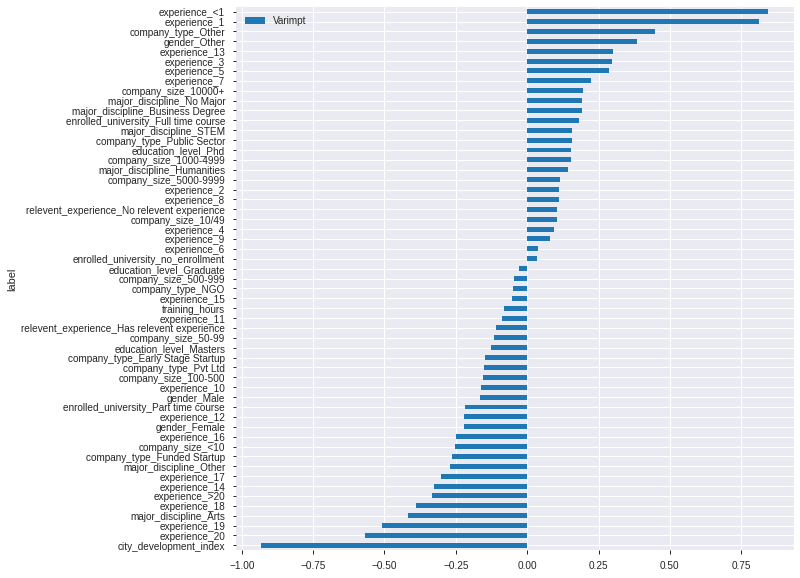

In [ ]:
varimpt.set_index('label').sort_values(by='Varimpt').plot(kind='barh',figsize=(10,10))

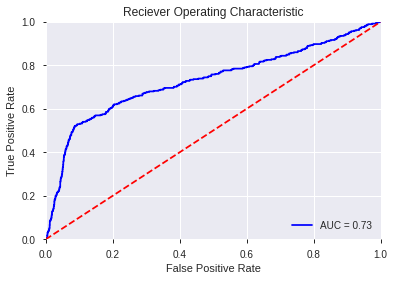

In [ ]:
import sklearn.metrics as metrics
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr,tpr, threshold = metrics.roc_curve(y_test,preds)
roc_auc = metrics.auc(fpr,tpr)

import matplotlib.pyplot as plt
plt.title('Reciever Operating Characteristic')
plt.plot(fpr,tpr,'b',label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

This shows 0.73 AUC which is quite decent as a baseline model.

In [ ]:
predictions = clf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91      1867
         1.0       0.53      0.24      0.33       372

    accuracy                           0.84      2239
   macro avg       0.70      0.60      0.62      2239
weighted avg       0.81      0.84      0.81      2239



<function matplotlib.pyplot.show>

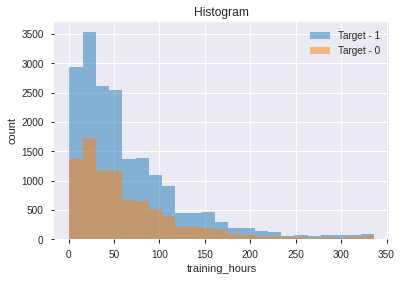

In [ ]:
plt.hist(df['training_hours'], bins=23, alpha=0.5, label='Target - 1')
plt.hist(df1['training_hours'], bins=23, alpha=0.5, label='Target - 0')
plt.legend(loc='upper right')
plt.title('Histogram')
plt.xlabel('training_hours')
plt.ylabel('count')
plt.show